In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import spearmanr, normaltest, anderson
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("student_performance_large_dataset.csv")
df.head()

Student_ID  Age  Gender  Study_Hours_per_Week Preferred_Learning_Style  \
0     S00001   18  Female                    48              Kinesthetic   
1     S00002   29  Female                    30          Reading/Writing   
2     S00003   20  Female                    47              Kinesthetic   
3     S00004   23  Female                    13                 Auditory   
4     S00005   19  Female                    24                 Auditory   

   Online_Courses_Completed Participation_in_Discussions  \
0                        14                          Yes   
1                        20                           No   
2                        11                           No   
3                         0                          Yes   
4                        19                          Yes   

   Assignment_Completion_Rate (%)  Exam_Score (%)  Attendance_Rate (%)  \
0                             100              69                   66   
1                              71              40                   57   
2                              60              43                   79   
3                              63              70                   60   
4                              59              63                   93   

  Use_of_Educational_Tech Self_Reported_Stress_Level  \
0                     Yes                       High   
1                     Yes                     Medium   
2                     Yes                        Low   
3                     Yes                        Low   
4                     Yes                     Medium   

   Time_Spent_on_Social_Media (hours/week)  Sleep_Hours_per_Night Final_Grade  
0                                        9                      8           C  
1                                       28                      8           D  
2                                       13                      7           D  
3                                       24                     10           B  
4                                       26                      8           C

## Missing Values

In [3]:
missing_values = df.isnull().sum()
display(missing_values)
# no missing values

# Remove duplicate rows
df.drop_duplicates(inplace=True)

Student_ID                                 0
Age                                        0
Gender                                     0
Study_Hours_per_Week                       0
Preferred_Learning_Style                   0
Online_Courses_Completed                   0
Participation_in_Discussions               0
Assignment_Completion_Rate (%)             0
Exam_Score (%)                             0
Attendance_Rate (%)                        0
Use_of_Educational_Tech                    0
Self_Reported_Stress_Level                 0
Time_Spent_on_Social_Media (hours/week)    0
Sleep_Hours_per_Night                      0
Final_Grade                                0
dtype: int64

In [4]:
# Convert Student_ID to string
df["Student_ID"] = df["Student_ID"].astype(str)

# Convert categorical columns to category dtype
categorical_cols = ["Gender", "Preferred_Learning_Style", "Self_Reported_Stress_Level", "Final_Grade"]
for col in categorical_cols:
    df[col] = df[col].astype("category")

# Ensure numerical columns are of the correct type
numerical_cols = ["Age", "Study_Hours_per_Week", "Online_Courses_Completed",
                  "Assignment_Completion_Rate (%)", "Exam_Score (%)", "Attendance_Rate (%)",
                  "Time_Spent_on_Social_Media (hours/week)", "Sleep_Hours_per_Night"]
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric)

In [5]:
# Standardize Gender values
df["Gender"] = df["Gender"].str.capitalize()  # Converts "male" to "Male", "female" to "Female"

# Ensure valid values in categorical columns
valid_stress_levels = ["Low", "Medium", "High"]
df = df[df["Self_Reported_Stress_Level"].isin(valid_stress_levels)]

valid_grades = ["A", "B", "C", "D", "F"]
df = df[df["Final_Grade"].isin(valid_grades)]

## Descriptive Statistics

In [6]:
display(df.describe())

Age  Study_Hours_per_Week  Online_Courses_Completed  \
count  10000.000000          10000.000000              10000.000000   
mean      23.478800             27.130300                 10.007900   
std        3.461986             13.002547                  6.136726   
min       18.000000              5.000000                  0.000000   
25%       20.000000             16.000000                  5.000000   
50%       23.000000             27.000000                 10.000000   
75%       27.000000             38.000000                 15.000000   
max       29.000000             49.000000                 20.000000   

       Assignment_Completion_Rate (%)  Exam_Score (%)  Attendance_Rate (%)  \
count                    10000.000000    10000.000000         10000.000000   
mean                        74.922000       70.188900            75.085100   
std                         14.675437       17.649447            14.749251   
min                         50.000000       40.000000            50.000000   
25%                         62.000000       55.000000            62.000000   
50%                         75.000000       70.000000            75.000000   
75%                         88.000000       85.000000            88.000000   
max                        100.000000      100.000000           100.000000   

       Time_Spent_on_Social_Media (hours/week)  Sleep_Hours_per_Night  
count                             10000.000000           10000.000000  
mean                                 14.936500               6.979300  
std                                   9.022639               1.996965  
min                                   0.000000               4.000000  
25%                                   7.000000               5.000000  
50%                                  15.000000               7.000000  
75%                                  23.000000               9.000000  
max                                  30.000000              10.000000

In [7]:
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
# Print column names to verify
print("Column names in dataset:", df.columns.tolist())

# Clean column names: Remove extra spaces before/after
df.columns = df.columns.str.strip()

# Define continuous variables (ensure names match the dataset)
continuous_vars = [
    "Age", "Study_Hours_per_Week", "Online_Courses_Completed", 
    "Assignment_Completion_Rate (%)", "Exam_Score (%)", "Attendance_Rate (%)", 
    "Time_Spent_on_Social_Media (hours/week)", "Sleep_Hours_per_Night"
]

# Check which columns exist in the dataset
existing_cols = [col for col in continuous_vars if col in df.columns]

# If some columns are missing, print a warning
missing_cols = set(continuous_vars) - set(existing_cols)
if missing_cols:
    print(f"Warning: The following columns are missing from the dataset: {missing_cols}")

# Filter dataset to only include existing columns
df_filtered = df[existing_cols].apply(pd.to_numeric, errors='coerce').dropna()

# Perform normality tests for continuous variables
for col in existing_cols:
    data = df_filtered[col].dropna()
    
    # D'Agostino-Pearson Test
    stat, p = normaltest(data)
    print(f"D'Agostino-Pearson Test for {col}: Statistic={stat:.4f}, p-value={p:.4f}")
    
    # Anderson-Darling Test
    result = anderson(data, dist='norm')
    print(f"Anderson-Darling Test for {col}: Statistic={result.statistic:.4f}")
    print(f"Critical Values: {result.critical_values}")
    print(f"Significance Levels: {result.significance_level}\n")


Column names in dataset: ['Student_ID', 'Age', 'Gender', 'Study_Hours_per_Week', 'Preferred_Learning_Style', 'Online_Courses_Completed', 'Participation_in_Discussions', 'Assignment_Completion_Rate (%)', 'Exam_Score (%)', 'Attendance_Rate (%)', 'Use_of_Educational_Tech', 'Self_Reported_Stress_Level', 'Time_Spent_on_Social_Media (hours/week)', 'Sleep_Hours_per_Night', 'Final_Grade']
D'Agostino-Pearson Test for Age: Statistic=12012.7357, p-value=0.0000
Anderson-Darling Test for Age: Statistic=160.0171
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]

D'Agostino-Pearson Test for Study_Hours_per_Week: Statistic=9432.6649, p-value=0.0000
Anderson-Darling Test for Study_Hours_per_Week: Statistic=117.2306
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]

D'Agostino-Pearson Test for Online_Courses_Completed: Statistic=12011.3154, p-value=0.0000
Anderson-Darling Test for Online_Courses_Completed: Stat

Mann-Whitney U Test Results:

Kruskal-Wallis Test Results:
Preferred_Learning_Style (Kruskal-Wallis): p-value = 0.54167
Self_Reported_Stress_Level (Kruskal-Wallis): p-value = 0.02659
Final_Grade (Kruskal-Wallis): p-value = 0.00000





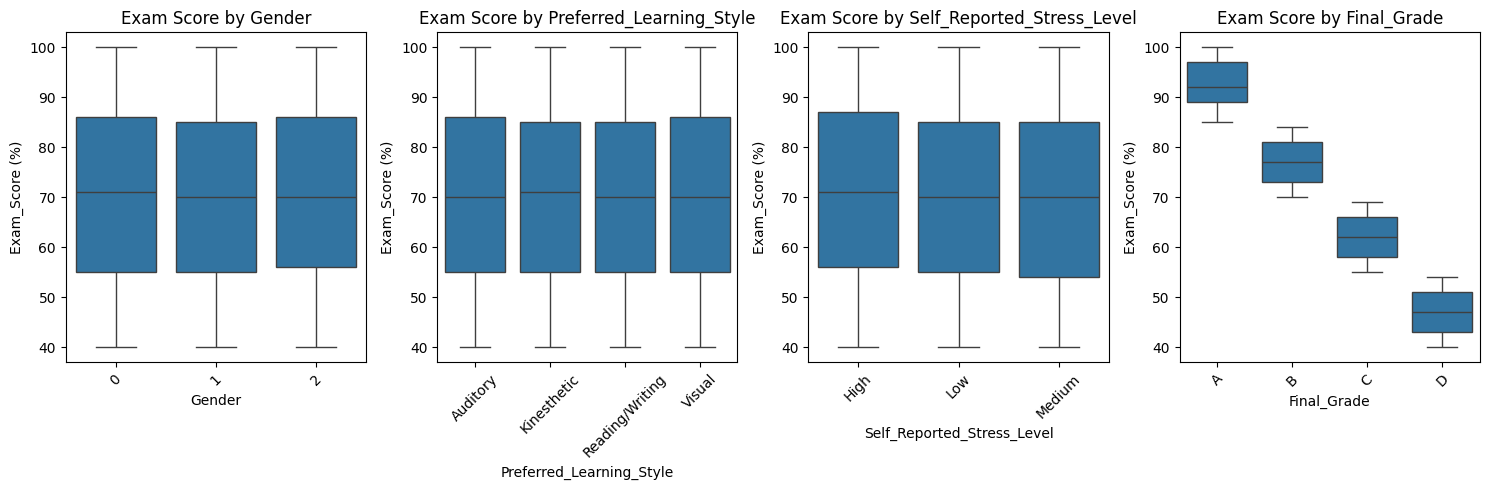

Mann-Whitney U Test Results:
Participation_in_Discussions (Mann-Whitney U): p-value = 0.88242
Use_of_Educational_Tech (Mann-Whitney U): p-value = 0.57714

Kruskal-Wallis Test Results:
Mann-Whitney U Test Results:
Participation_in_Discussions (Mann-Whitney U): p-value = 0.88242
Use_of_Educational_Tech (Mann-Whitney U): p-value = 0.57714

Kruskal-Wallis Test Results:





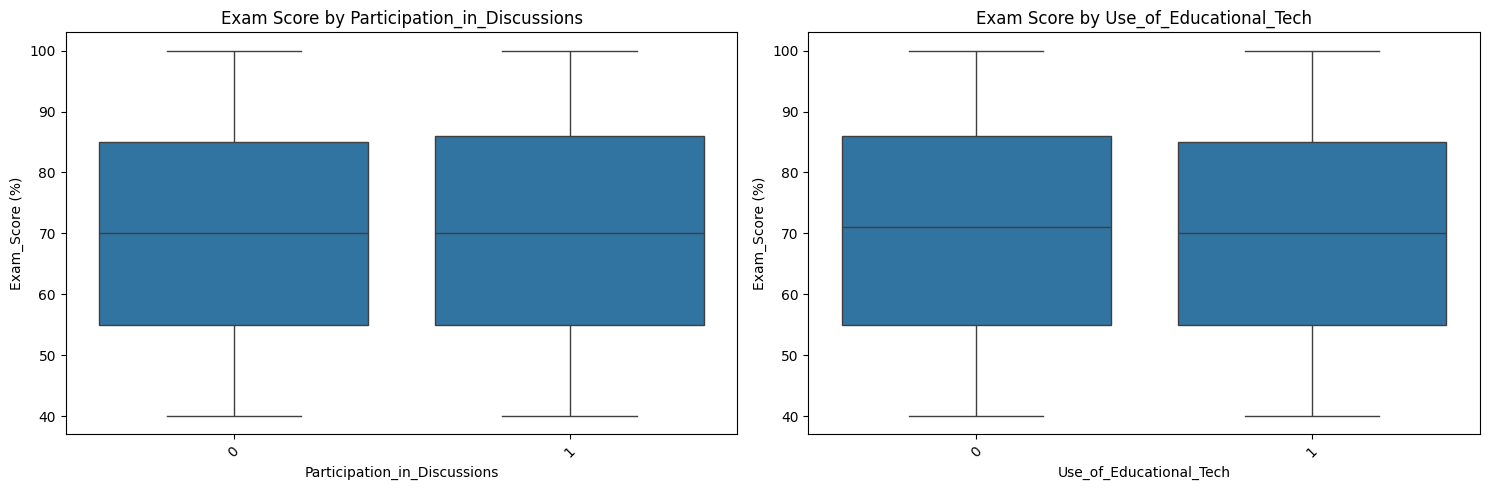

In [9]:
### Mann-Whitney U Test (for two groups) and Kruskal-Wallis Test Alternate of ANOVA
binary_vars = ["Gender"]  
multi_group_vars = ["Preferred_Learning_Style", "Self_Reported_Stress_Level", "Final_Grade"]  
binary_vars = ["Gender"]
multi_group_vars = ["Preferred_Learning_Style", "Self_Reported_Stress_Level", "Final_Grade"] 


mann_whitney_results = {}
kruskal_wallis_results = {}

for var in multi_group_vars:
    groups = [df[df[var] == category]["Exam_Score (%)"] for category in df[var].unique()]
    kw_test = stats.kruskal(*groups)
    kruskal_wallis_results[var] = {"Test": "Kruskal-Wallis", "p-value": kw_test.pvalue}


print("Mann-Whitney U Test Results:")
for var, result in mann_whitney_results.items():
    print(f"{var} ({result['Test']}): p-value = {result['p-value']:.5f}")

print("\nKruskal-Wallis Test Results:")
for var, result in kruskal_wallis_results.items():
    print(f"{var} ({result['Test']}): p-value = {result['p-value']:.5f}")
print("\n\n")

plt.figure(figsize=(15, 5))
for i, var in enumerate(binary_vars + multi_group_vars, 1):
    plt.subplot(1, len(binary_vars + multi_group_vars), i)
    sns.boxplot(x=df[var], y=df["Exam_Score (%)"])
    plt.title(f"Exam Score by {var}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
### Impact of Participation and Technology Use on Exam Performance

df = df.drop(columns=['Student_ID'])
binary_vars = ['Participation_in_Discussions', 'Use_of_Educational_Tech']
multi_group_vars = [var for var in df.columns if df[var].nunique() > 2 and df[var].dtype == 'object']

# Store results
mann_whitney_results = {}
kruskal_wallis_results = {}

# Mann-Whitney U Test for binary variables
for var in binary_vars:
    if df[var].nunique() == 2:  # Ensure binary
        group1 = df[df[var] == df[var].unique()[0]]['Exam_Score (%)']
        group2 = df[df[var] == df[var].unique()[1]]['Exam_Score (%)']
        mw_test = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        mann_whitney_results[var] = {"Test": "Mann-Whitney U", "p-value": mw_test.pvalue}

# Kruskal-Wallis Test for multi-group variables
for var in multi_group_vars:
    groups = [df[df[var] == category]['Exam_Score (%)'] for category in df[var].unique()]
    kw_test = stats.kruskal(*groups)
    kruskal_wallis_results[var] = {"Test": "Kruskal-Wallis", "p-value": kw_test.pvalue}

# Print results
print("Mann-Whitney U Test Results:")
for var, result in mann_whitney_results.items():
    print(f"{var} ({result['Test']}): p-value = {result['p-value']:.5f}")

print("\nKruskal-Wallis Test Results:")
for var, result in kruskal_wallis_results.items():
    print(f"{var} ({result['Test']}): p-value = {result['p-value']:.5f}")

excluded_vars = ['Gender', 'Self_Reported_Stress_Level', 'Final_Grade','Preferred_Learning_Style']
multi_group_vars = [var for var in df.columns if df[var].nunique() > 2 and df[var].dtype == 'object' and var not in excluded_vars]

# Store results
mann_whitney_results = {}
kruskal_wallis_results = {}

# Mann-Whitney U Test for binary variables
for var in binary_vars:
    if df[var].nunique() == 2:  # Ensure binary
        group1 = df[df[var] == df[var].unique()[0]]['Exam_Score (%)']
        group2 = df[df[var] == df[var].unique()[1]]['Exam_Score (%)']
        mw_test = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        mann_whitney_results[var] = {"Test": "Mann-Whitney U", "p-value": mw_test.pvalue}

# Kruskal-Wallis Test for multi-group variables
for var in multi_group_vars:
    groups = [df[df[var] == category]['Exam_Score (%)'] for category in df[var].unique()]
    kw_test = stats.kruskal(*groups)
    kruskal_wallis_results[var] = {"Test": "Kruskal-Wallis", "p-value": kw_test.pvalue}

# Print results
print("Mann-Whitney U Test Results:")
for var, result in mann_whitney_results.items():
    print(f"{var} ({result['Test']}): p-value = {result['p-value']:.5f}")

print("\nKruskal-Wallis Test Results:")
for var, result in kruskal_wallis_results.items():
    print(f"{var} ({result['Test']}): p-value = {result['p-value']:.5f}")
print("\n\n")
# Visualization: Boxplots
plt.figure(figsize=(15, 5))
plot_vars = [var for var in binary_vars + multi_group_vars if var not in excluded_vars]
for i, var in enumerate(plot_vars, 1):
    plt.subplot(1, len(plot_vars), i)
    sns.boxplot(x=df[var], y=df['Exam_Score (%)'])
    plt.title(f"Exam Score by {var}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



## Distribution of Numerical Features

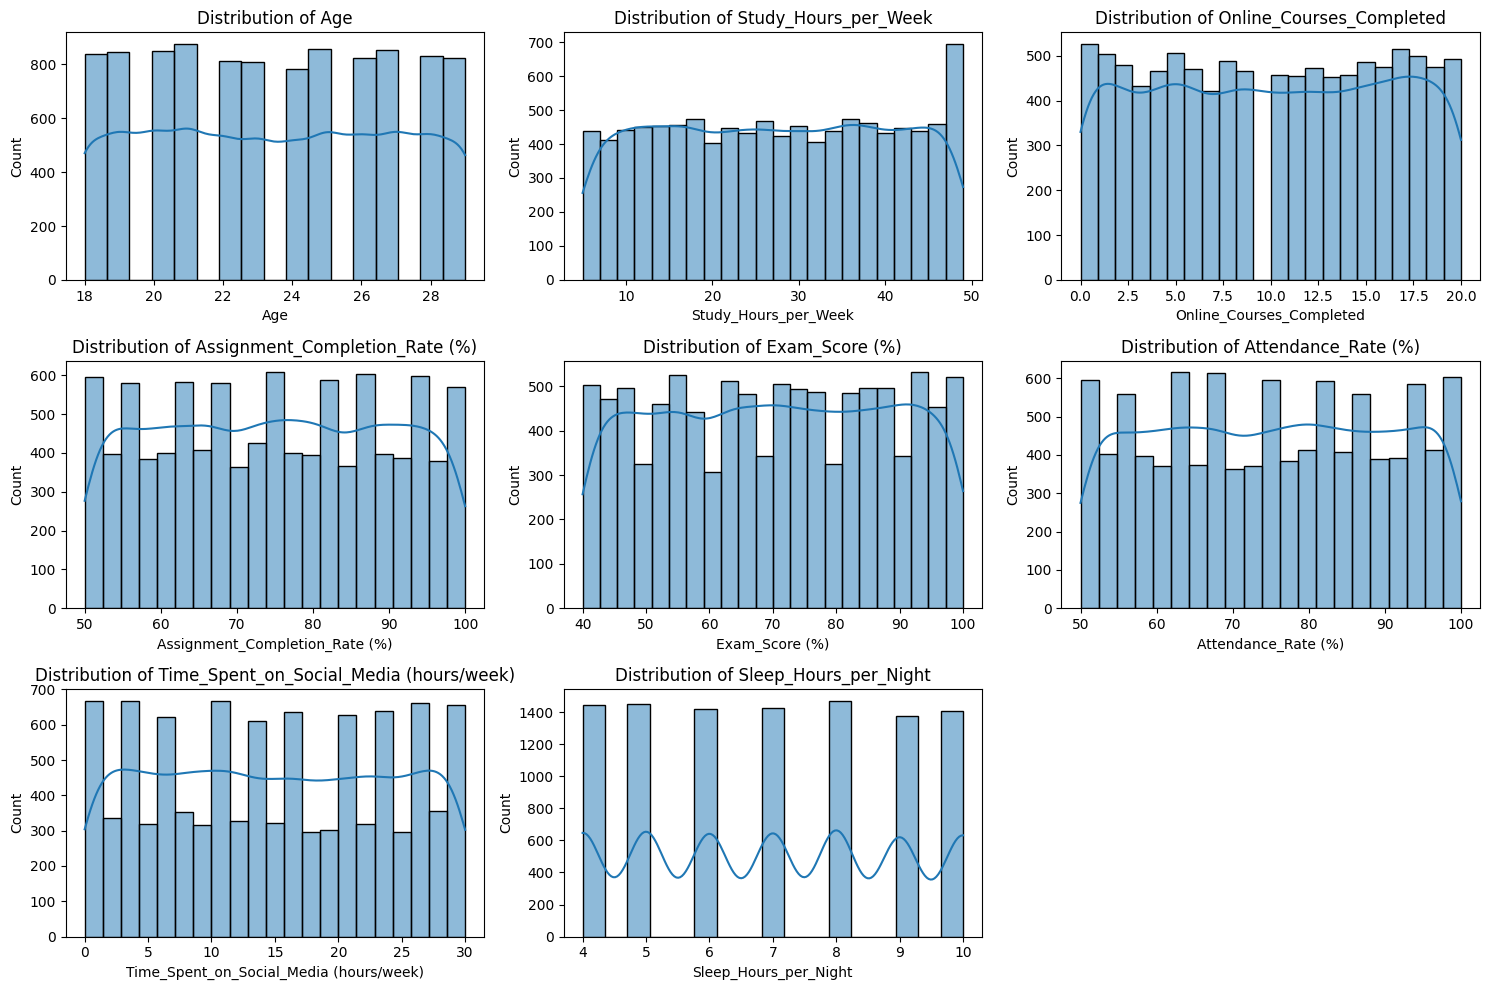

In [10]:
# Plot the distribution of numerical features
numerical_features = ['Age', 'Study_Hours_per_Week', 'Online_Courses_Completed', 
                      'Assignment_Completion_Rate (%)', 'Exam_Score (%)', 
                      'Attendance_Rate (%)', 'Time_Spent_on_Social_Media (hours/week)', 
                      'Sleep_Hours_per_Night']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

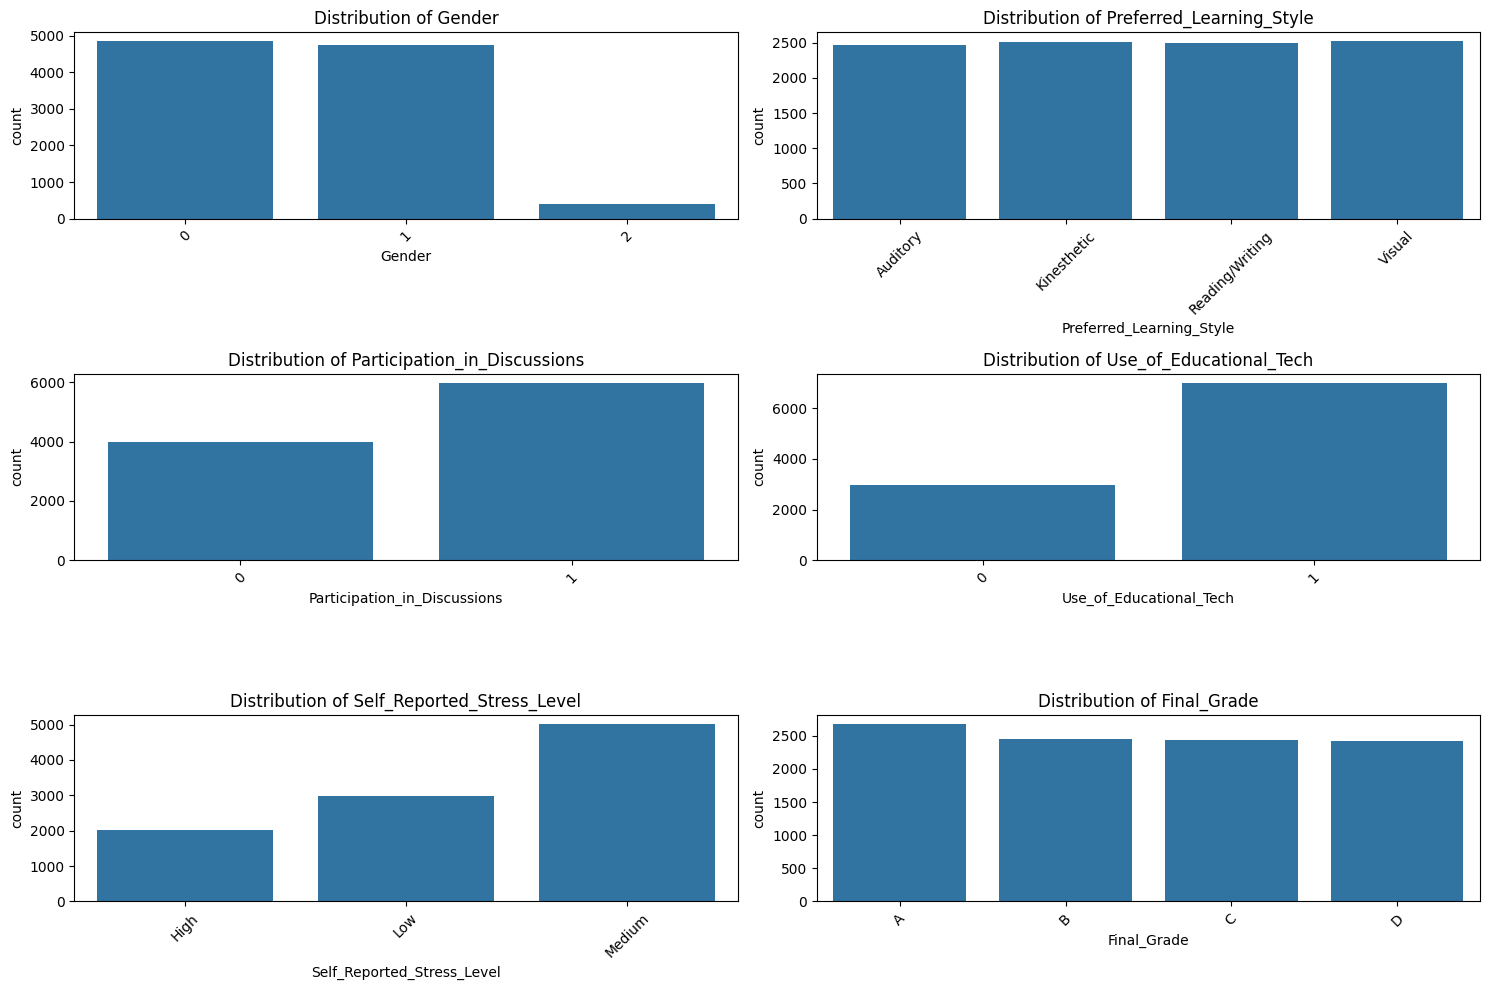

In [11]:
# Plot the distribution of categorical features
categorical_features = ['Gender', 'Preferred_Learning_Style', 'Participation_in_Discussions', 
                        'Use_of_Educational_Tech', 'Self_Reported_Stress_Level', 'Final_Grade']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=df[feature])
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlation Analysis

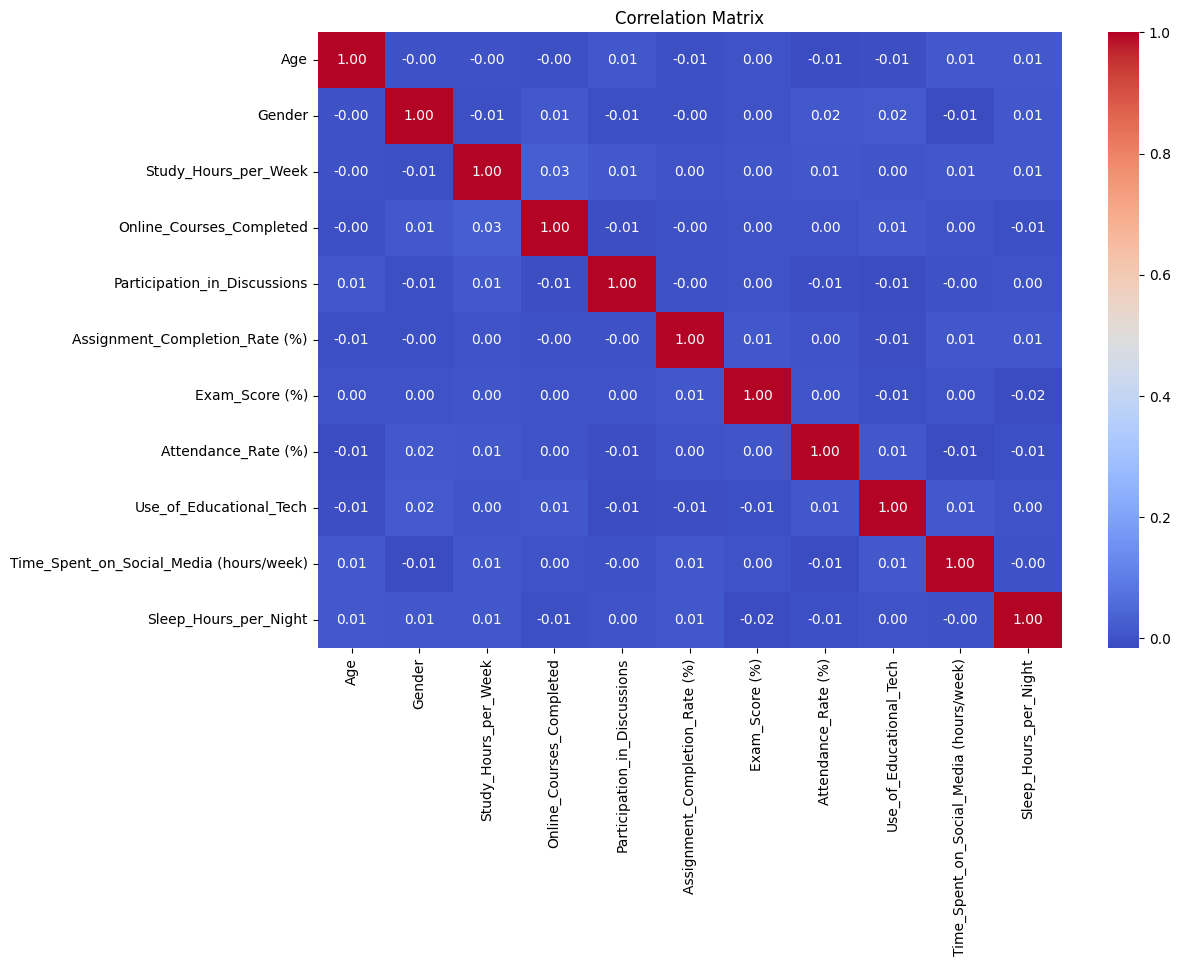

In [12]:
numerical_df = df.select_dtypes(include=[np.number])

correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Feature Engineering

Final_Grade and Exam_Score (%): 0.9679908161531746
Study_Efficiency and Exam_Score (%): 0.33322114447258605
Study_Efficiency and Final_Grade: 0.3201675278152358
Participation_Effectiveness and Assignment_Completion_Rate (%): 0.22681725693662885
Social_Media_Impact and Exam_Score (%): 0.15479216591532902
Social_Media_Impact and Final_Grade: 0.14867006070595665
Stress_Performance and Exam_Score (%): 0.46143429910552203
Stress_Performance and Final_Grade: 0.44780169951297755
Stress_Performance and Study_Efficiency: 0.1395738785779449
Sleep_Efficiency and Exam_Score (%): 0.6783175107951442
Sleep_Efficiency and Final_Grade: 0.6565317978753926
Sleep_Efficiency and Study_Efficiency: 0.22880918591964394
Sleep_Efficiency and Social_Media_Impact: 0.09976175641689532
Sleep_Efficiency and Stress_Performance: 0.3234567594987379
Attendance_Effectiveness and Exam_Score (%): 0.7812778585255508
Attendance_Effectiveness and Attendance_Rate (%): 0.6079677450970647
Attendance_Effectiveness and Final_Grade

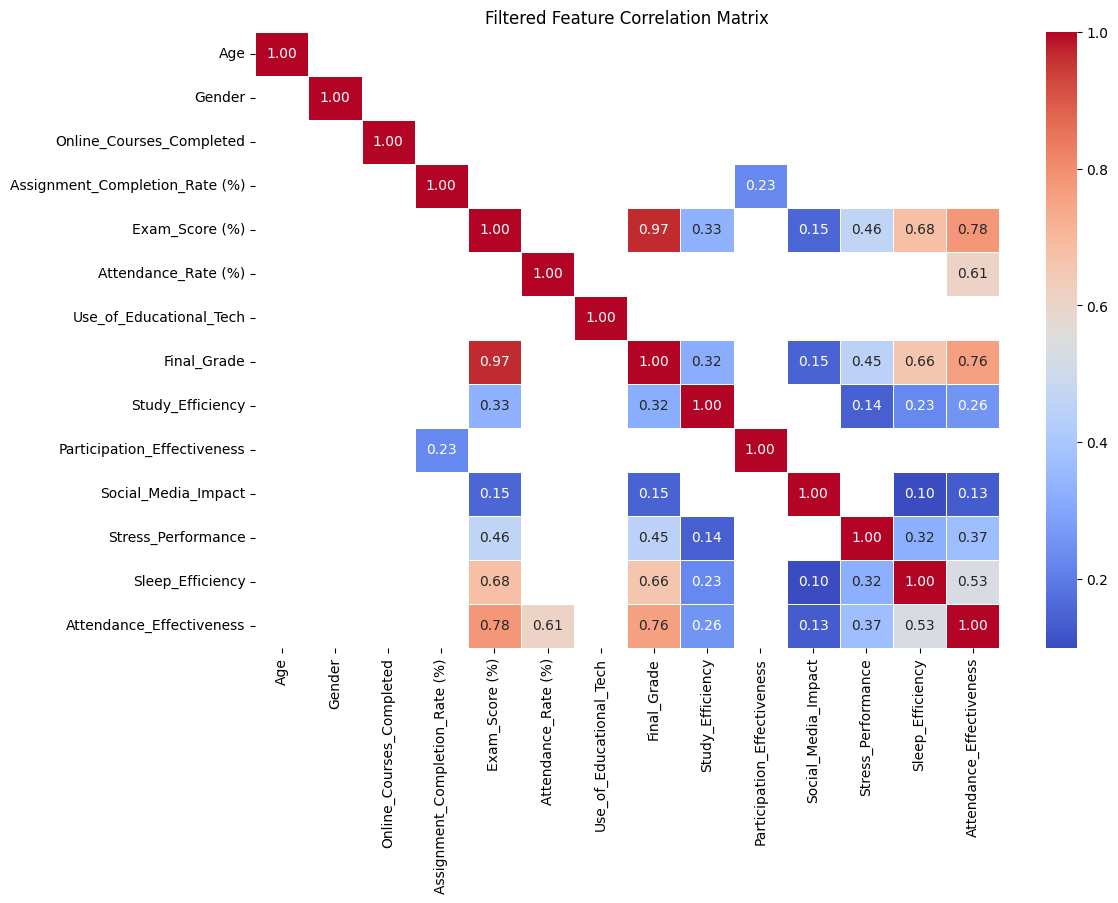

In [13]:
# Load dataset (assuming df is already loaded)
df.drop('Student_ID', axis=1, inplace=True, errors='ignore')

# Encoding categorical variables
label_encoders = {}

# Define an ordinal mapping for Final Grade
final_grade_mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}
df['Final_Grade'] = df['Final_Grade'].map(final_grade_mapping)
df['Final_Grade'] = pd.to_numeric(df['Final_Grade'])

# Use label encoding for categorical columns (except Final Grade)
categorical_cols = ['Participation_in_Discussions',"Self_Reported_Stress_Level"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature Engineering with log transformation to handle skewed data
epsilon = 1  # Small constant to avoid divide-by-zero errors
df['Study_Efficiency'] = df['Exam_Score (%)'] / (df['Study_Hours_per_Week'] + epsilon)
df['Participation_Effectiveness'] = df['Assignment_Completion_Rate (%)'] * df['Participation_in_Discussions']
df['Social_Media_Impact'] = df['Exam_Score (%)'] / (df['Time_Spent_on_Social_Media (hours/week)'] + epsilon)
df['Stress_Performance'] = df['Exam_Score (%)'] / (df['Self_Reported_Stress_Level'] + epsilon)
df['Sleep_Efficiency'] = df['Exam_Score (%)'] / (df['Sleep_Hours_per_Night'] + epsilon)
df['Attendance_Effectiveness'] = df['Exam_Score (%)'] * df['Attendance_Rate (%)']


# Drop original columns used to create new features
df.drop(['Study_Hours_per_Week', 'Participation_in_Discussions', 'Time_Spent_on_Social_Media (hours/week)',
         'Self_Reported_Stress_Level', 'Sleep_Hours_per_Night'], axis=1, inplace=True)



df_numeric=df.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()


high_corr = correlation_matrix[(correlation_matrix > 0.09) | (correlation_matrix < -0.09)]
high_corr = high_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)


corr_columns=[]
for i in range(len(high_corr)):
    for j in range(i):
        if abs(high_corr.iloc[i, j]) > 0.09 or abs(high_corr.iloc[i, j]) < -0.09:
            print(f"{high_corr.index[i]} and {high_corr.columns[j]}: {high_corr.iloc[i, j]}")
            corr_columns.append(high_corr.index[i])
            corr_columns.append(high_corr.columns[j])
corr_columns = list(set(corr_columns))


# Correlation Analysis - Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Filtered Feature Correlation Matrix")
plt.show()


In [14]:
df[corr_columns].dtypes
df= df[corr_columns]
df.head()

Study_Efficiency  Social_Media_Impact  Exam_Score (%)  \
0          1.408163             6.900000              69   
1          1.290323             1.379310              40   
2          0.895833             3.071429              43   
3          5.000000             2.800000              70   
4          2.520000             2.333333              63   

   Attendance_Effectiveness  Assignment_Completion_Rate (%)  Final_Grade  \
0                      4554                             100            2   
1                      2280                              71            1   
2                      3397                              60            1   
3                      4200                              63            3   
4                      5859                              59            2   

   Participation_Effectiveness  Stress_Performance  Attendance_Rate (%)  \
0                          100           69.000000                   66   
1                            0           13.333333                   57   
2                            0           21.500000                   79   
3                           63           35.000000                   60   
4                           59           21.000000                   93   

   Sleep_Efficiency  
0          7.666667  
1          4.444444  
2          5.375000  
3          6.363636  
4          7.000000

## Univariate Analysis

In [15]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=5, cols=2, subplot_titles=df.columns)

# Add a histogram for each column
for i, col in enumerate(df.columns):
    row = (i // 2) + 1  # Integer division to determine row
    col_num = (i % 2) + 1  # Modulo to determine column
    fig.add_trace(
        go.Histogram(x=df[col], name=col, nbinsx=30),
        row=row, col=col_num
    )

# Update layout for better visibility
fig.update_layout(
    height=1200,
    width=1000,
    title_text="Distribution of All Variables",
    showlegend=False
)
fig.show()

## Bivariate Analysis

### Attendance Effectiveness vs. Final Grade

In [16]:
fig2 = px.scatter(df, x="Attendance_Effectiveness", y="Exam_Score (%)",
                  trendline="ols",
                  title="Relationship: Attendance Effectiveness vs Exam Score",
                  labels={"Attendance_Effectiveness": "Attendance Effectiveness", "Exam_Score (%)": "Exam Score (%)"})
fig2.update_traces(marker=dict(opacity=0))
fig2.data[1].update(marker=dict(opacity=1))
fig2.update_layout(template="plotly_white")
fig2.show()

### Sleep Efficiency vs Exam Score (%)

In [17]:
fig3 = px.scatter(df, x="Sleep_Efficiency", y="Exam_Score (%)",
                  trendline="ols",
                  title="Relationship: Sleep Efficiency vs Exam Score",
                  labels={"Sleep_Efficiency": "Sleep Efficiency", "Exam_Score (%)": "Exam Score (%)"})
fig3.update_traces(line=dict(color='red'))  
fig3.update_layout(template="plotly_white")
fig3.show()

### Sleep Efficiency vs Final Grade

In [18]:
fig4 = px.scatter(df, x="Sleep_Efficiency", y="Final_Grade",
                  trendline="ols",
                  title="Relationship: Sleep Efficiency vs Final Grade",
                  labels={"Sleep_Efficiency": "Sleep Efficiency", "Final_Grade": "Final Grade"})
fig4.update_traces(marker=dict(color='#636efa'))  
fig4.data[1].update(marker=dict(color='red'))  
fig4.update_layout(template="plotly_white")
fig4.show()

### Attendance Effectiveness vs Final Grade

In [19]:
fig5 = px.scatter(df, x="Attendance_Effectiveness", y="Final_Grade",
                  trendline="ols",
                  title="Relationship: Attendance Effectiveness vs Final Grade",
                  labels={"Attendance_Effectiveness": "Attendance Effectiveness", "Final_Grade": "Final Grade"})
fig5.update_traces(line=dict(color='red'))  
fig5.update_layout(template="plotly_white")
fig5.show()

## Correlation Network Graph

In [20]:

import networkx as nx

# Create graph from correlation matrix, only include edges above a threshold
threshold = 0.09
G = nx.Graph()
corr_matrix = df.corr()
# remove columns Age and 

# Add nodes
for col in corr_matrix.columns:
    G.add_node(col)

for i, col1 in enumerate(corr_matrix.columns):
    for j, col2 in enumerate(corr_matrix.columns):
        if i < j:
            corr_val = corr_matrix.loc[col1, col2]
            if abs(corr_val) >= threshold:
                G.add_edge(col1, col2, weight=corr_val)

# Get layout positions for nodes
pos = nx.spring_layout(G, seed=42)  # for reproducibility

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=2, color='#888'),
    hoverinfo='none',
    mode='lines'
)

node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    marker=dict(
        size=20,
        color='skyblue',
        line_width=2
    ),
    textfont=dict(size=9),  
    hoverinfo='text'
)

fig_network = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            title="Correlation Network Graph",
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20, l=5, r=5, t=40),
                            template="plotly_white"
                        ))
fig_network.show()


## Density Contour Plots for Key Relationships

In [21]:
fig_density1 = px.density_contour(df, x="Attendance_Effectiveness", y="Exam_Score (%)",
                                  title="Density Contour: Attendance Effectiveness vs Exam Score",
                                  labels={"Attendance_Effectiveness": "Attendance Effectiveness", "Exam_Score (%)": "Exam Score (%)"})
fig_density1.update_layout(template="plotly_white")
fig_density1.show()

# Density Contour: Sleep Efficiency vs Exam Score (%)
fig_density2 = px.density_contour(df, x="Sleep_Efficiency", y="Exam_Score (%)",
                                  title="Density Contour: Sleep Efficiency vs Exam Score",
                                  labels={"Sleep_Efficiency": "Sleep Efficiency", "Exam_Score (%)": "Exam Score (%)"})
fig_density2.update_layout(template="plotly_white")
fig_density2.show()


## Violin Plots by Exam Score Groups

In [22]:
df['Exam_Score_Group'] = pd.qcut(df['Exam_Score (%)'], q=3, labels=["Low", "Medium", "High"])

# Violin plot for Sleep Efficiency by Exam Score Group
fig_violin = px.violin(df, x="Exam_Score_Group", y="Sleep_Efficiency",
                       title="Violin Plot: Sleep Efficiency across Exam Score Groups",
                       labels={"Exam_Score_Group": "Exam Score Group", "Sleep_Efficiency": "Sleep Efficiency"})
fig_violin.update_layout(template="plotly_white")
fig_violin.show()

## Models Reduction

In [23]:
df.rename(columns={
    "Assignment_Completion_Rate (%)": "Assignment_Completion_Rate",
    "Exam_Score (%)": "Exam_Score",
    "Attendance_Rate (%)": "Attendance_Rate"
}, inplace=True)

X = df.drop(columns=["Exam_Score","Exam_Score_Group"])
y = df["Exam_Score"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

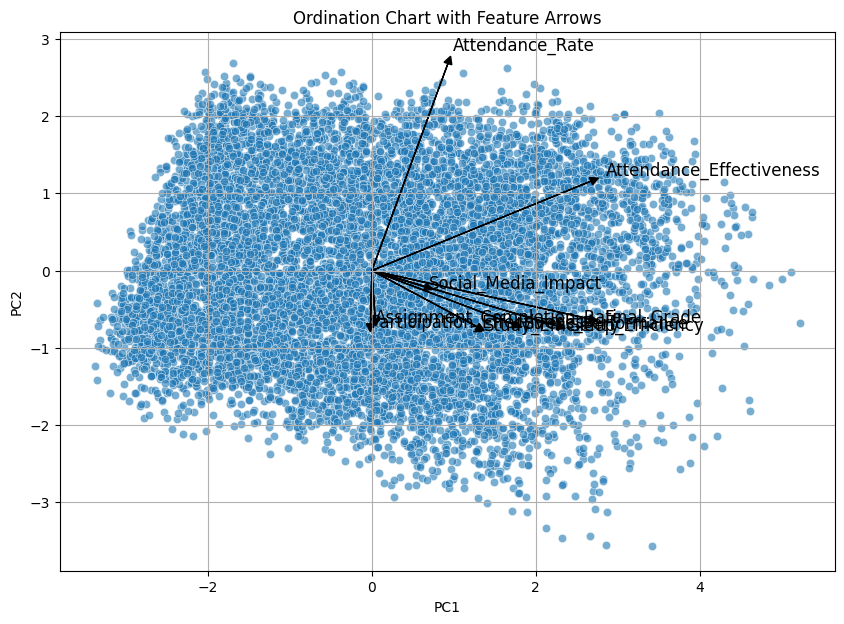

In [24]:
# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(principal_components, columns=["PC1", "PC2"])

# Create a biplot with arrows
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], alpha=0.6)

# Add arrows for each feature
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(X.columns):
    ax.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, head_width=0.1, head_length=0.1, color='black')
    ax.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature, color='black', fontsize=12)

# Labels and title
#ax.set_xlabel("Principal Component 1")
#ax.set_ylabel("Principal Component 2")
ax.set_title("Ordination Chart with Feature Arrows")
plt.grid()
plt.show()

### Linear Regression

Linear Regression Model Mean Squared Error: 7.009532600391138


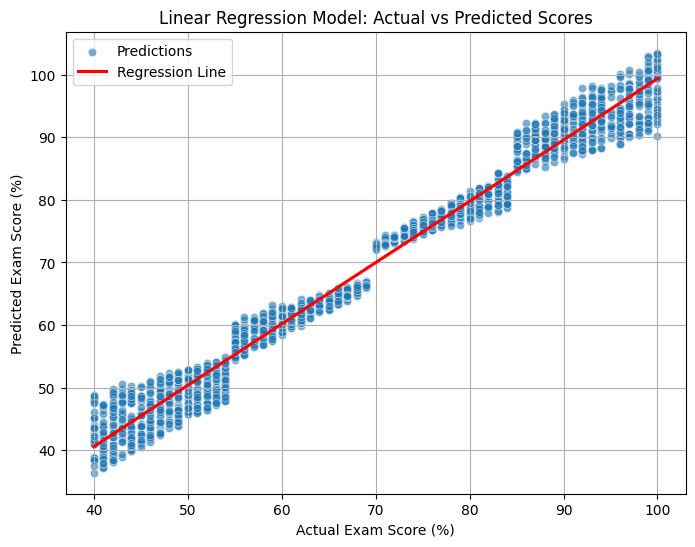

In [25]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_predictions)
print("Linear Regression Model Mean Squared Error:", linear_mse)

# Visualization - Actual vs Predicted with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=linear_predictions, alpha=0.6, label="Predictions")

# Fit regression line
sns.regplot(x=y_test, y=linear_predictions, scatter=False, color='red', label="Regression Line")

plt.xlabel("Actual Exam Score (%)")
plt.ylabel("Predicted Exam Score (%)")
plt.title("Linear Regression Model: Actual vs Predicted Scores")
plt.legend()
plt.grid()
plt.show()

### OLS Model

OLS Model Mean Squared Error: 7.009532600391152
OLS Model AIC 38613.15995660725


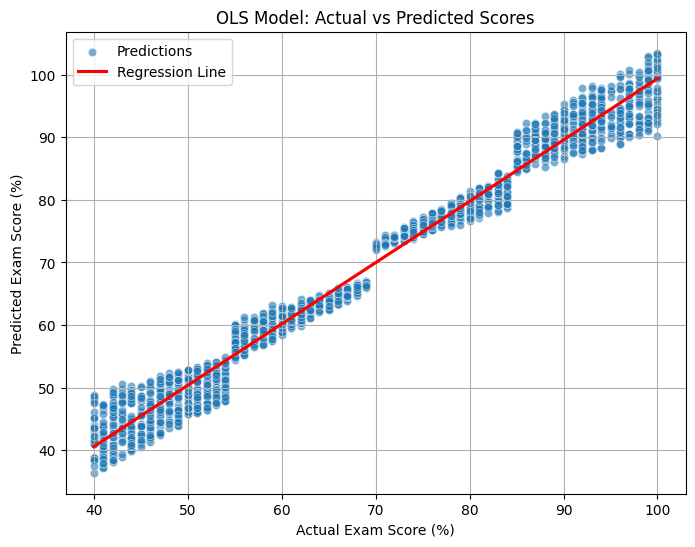

In [26]:
# Add constant for OLS model
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
# Train OLS model
ols_model = sm.OLS(y_train, X_train_const).fit()

# Predict on test data
ols_predictions = ols_model.predict(X_test_const)

# Compute Mean Squared Error (MSE)
ols_mse = mean_squared_error(y_test, ols_predictions)
print("OLS Model Mean Squared Error:", ols_mse)
print("OLS Model AIC", ols_model.aic)

# Visualization - Actual vs Predicted with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=ols_predictions, alpha=0.6, label="Predictions")

# Fit regression line
sns.regplot(x=y_test, y=ols_predictions, scatter=False, color='red', label="Regression Line")

plt.xlabel("Actual Exam Score (%)")
plt.ylabel("Predicted Exam Score (%)")
plt.title("OLS Model: Actual vs Predicted Scores")
plt.legend()
plt.grid()
plt.show()

### Support Vector Machine

SVM Model Mean Squared Error: 3.079062191920533


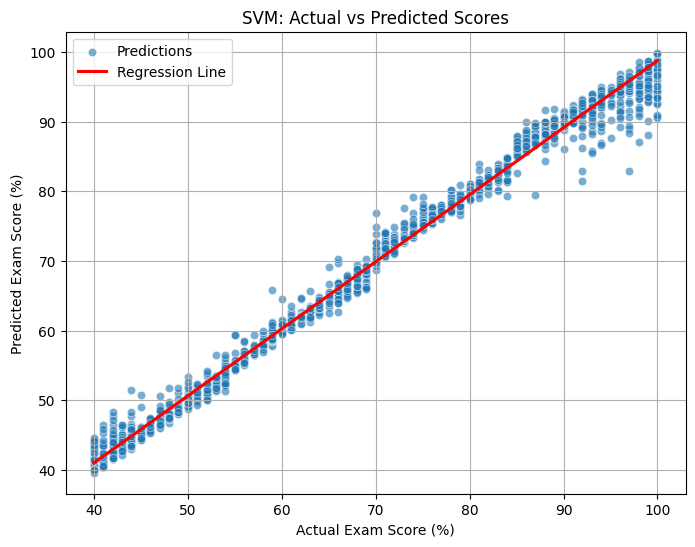

In [27]:
from sklearn.svm import SVR

# Support Vector Regression (SVR) model
svm_model = SVR(kernel='rbf')  # Using Radial Basis Function kernel
svm_model.fit(X_train, y_train)
# Predict on test data
svm_predictions = svm_model.predict(X_test)
# Compute Mean Squared Error (MSE)
svm_mse = mean_squared_error(y_test, svm_predictions)
print("SVM Model Mean Squared Error:", svm_mse)

# Visualization - Actual vs Predicted with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=svm_predictions, alpha=0.6, label="Predictions")

# Fit regression line
sns.regplot(x=y_test, y=svm_predictions, scatter=False, color='red', label="Regression Line")

plt.xlabel("Actual Exam Score (%)")
plt.ylabel("Predicted Exam Score (%)")
plt.title("SVM: Actual vs Predicted Scores")
plt.legend()
plt.grid()
plt.show()

### GLM Gaussian

GLM (Gaussian Family) Model Mean Squared Error: 7.009532600391152
GLM (Gaussian Family) AIC: 38613.15995660724


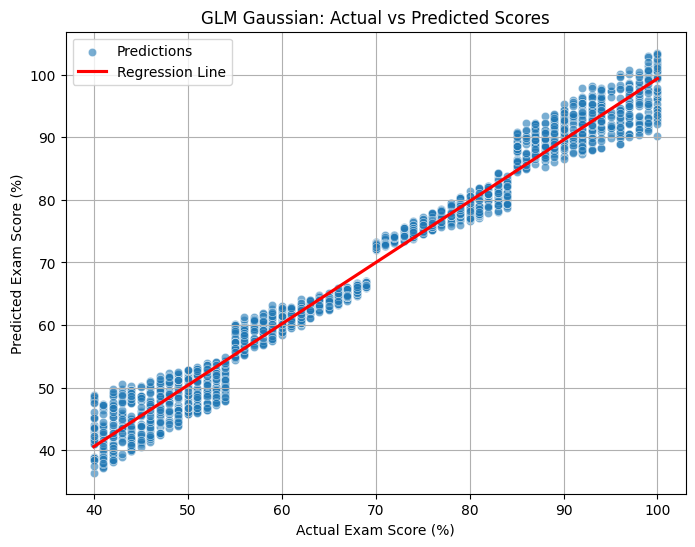

In [28]:
# GLM Model (Gaussian Family)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian()).fit()
glm_predictions = glm_model.predict(X_test_const)
glm_mse = mean_squared_error(y_test, glm_predictions)
glm_aic = glm_model.aic
print("GLM (Gaussian Family) Model Mean Squared Error:", glm_mse)
print("GLM (Gaussian Family) AIC:", glm_aic)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=glm_predictions, alpha=0.6, label="Predictions")

# Fit regression line
sns.regplot(x=y_test, y=glm_predictions, scatter=False, color='red', label="Regression Line")

plt.xlabel("Actual Exam Score (%)")
plt.ylabel("Predicted Exam Score (%)")
plt.title("GLM Gaussian: Actual vs Predicted Scores")
plt.legend()
plt.grid()
plt.show()

### GLM Poisson


In [29]:
import statsmodels.formula.api as smf

# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)
#  Null model
null_model = smf.glm('Exam_Score ~ 1', data=train, family=sm.families.Poisson()).fit()
null_predictions = null_model.predict()
print("Null model AIC", null_model.aic)

# Candidate GLMs
model_1 = smf.glm('Exam_Score ~ Attendance_Effectiveness + Sleep_Efficiency', data=train, family=sm.families.Poisson()).fit()
model_2 = smf.glm('Exam_Score ~ Attendance_Effectiveness + Sleep_Efficiency + Stress_Performance', data=train, family=sm.families.Poisson()).fit()
model_3 = smf.glm('Exam_Score ~ Attendance_Effectiveness + Sleep_Efficiency + Stress_Performance + Study_Efficiency', data=train, family=sm.families.Poisson()).fit()
model_4 = smf.glm('Exam_Score ~ Attendance_Effectiveness + Sleep_Efficiency + Stress_Performance + Study_Efficiency + Social_Media_Impact', data=train, family=sm.families.Poisson()).fit()
model_5 = smf.glm('Exam_Score ~ Attendance_Effectiveness + Stress_Performance + Study_Efficiency + Social_Media_Impact', data=train, family=sm.families.Poisson()).fit()
model_6 = smf.glm('Exam_Score ~ Attendance_Effectiveness + Sleep_Efficiency + Stress_Performance + Social_Media_Impact', data=train, family=sm.families.Poisson()).fit()
model_7 = smf.glm('Exam_Score ~ Attendance_Effectiveness + Stress_Performance + Study_Efficiency', data=train, family=sm.families.Poisson()).fit()

models = {
    'Null Model': null_model,
    'Model 1': model_1,
    'Model 2': model_2,
    'Model 3': model_3,
    'Model 4': model_4,
    'Model 5': model_5,
    'Model 6': model_6
}
# Create AIC table
aic_table = pd.DataFrame(
    {name: [model.aic] for name, model in models.items()},
    index=['AIC']
).T

# Sort AIC table by AIC value
aic_table = aic_table.sort_values(by='AIC')

print("\n--- AIC Table ---\n")
print(aic_table)

Null model AIC 84701.31768596312

--- AIC Table ---

                     AIC
Model 4     59216.465546
Model 3     59250.517919
Model 6     59580.385491
Model 2     59615.318869
Model 1     60263.074540
Model 5     61766.398939
Null Model  84701.317686


GLM Poisson Model 4 Mean Squared Error: 93.76820719193147


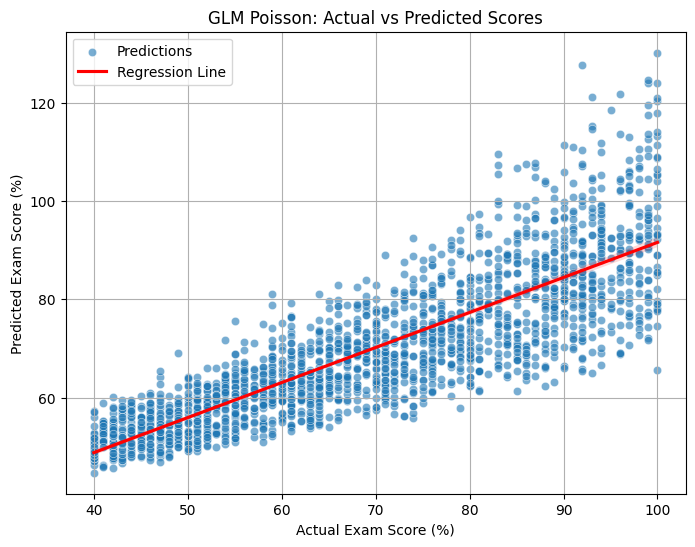

In [30]:
test['predicted'] = model_4.predict(test)
model_4_mse = mean_squared_error(test['Exam_Score'], test['predicted'] )
print("GLM Poisson Model 4 Mean Squared Error:", model_4_mse)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=test['predicted'], alpha=0.6, label="Predictions")

# Fit regression line
sns.regplot(x=y_test, y=test['predicted'], scatter=False, color='red', label="Regression Line")

plt.xlabel("Actual Exam Score (%)")
plt.ylabel("Predicted Exam Score (%)")
plt.title("GLM Poisson: Actual vs Predicted Scores")
plt.legend()
plt.grid()
plt.show()